# Chief-deputy Rendezvous and Docking on an Elliptical Orbit
© 2023 Tomohiro Sasaki, All Rights Reserved.

## Import libraries

In [1]:
using Plots; gr()
using LinearAlgebra
using Revise
using CDDP # import CDDP module

using DifferentialEquations
using DataInterpolations
using BenchmarkTools
using Printf


## Define Simulation Setup

In [3]:
tf = 5000. # final time 
tN = 500 # number of time steps
dt = tf/tN # time step
hN = 50; # horizon length

## Define Dynamics Model

In [19]:
includet("../src/models/chiefdeputy.jl")
model = ChiefDeputy()

# initial state
x_init = model.x_init
@printf("Initial State: [%f, %f, %f, %f, %f, %f, %f] \n", x_init...)

# final state
x_final = model.x_final
@printf("Final State: [%f, %f, %f, %f, %f, %f, %f] \n", x_final...)

# model dimensions
nx, nu = model.dims.nx, model.dims.nu
@printf("nx: %i, nu: %i", nx, nu)

Initial State: [-0.469463, 0.341046, 0.170523, 0.037865, 0.208491, 0.104245, 0.400000] 
Final State: [-0.187983, 0.136562, 0.068281, 0.015162, 0.083484, 0.041742, 0.390000] 


nx: 6, nu: 3

## Propagate Chief Spacecraft Orbit

In [8]:
Œ, _ = initialize_trajectory(model, tf, tN, model.œ_init, model.fc!)
model.params.Œ = Œ;

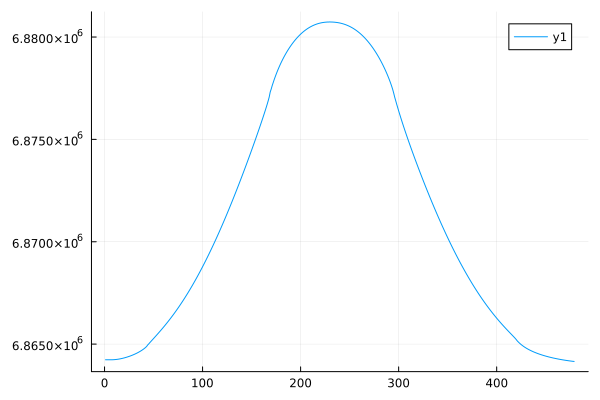

In [9]:
plot(Œ[1,:])

## Define Cost Functions for Trajecotry Optimization

In [20]:
function running_cost(
    x::Vector,
    u::Vector,
    x_ref::Vector{Float64};
)
    Q = zeros(6, 6)
    R = Diagonal(1e+1*[1; 1; 1])
    return 0.5 * transpose(x - x_ref) * Q * (x - x_ref) + 0.5 * transpose(u) * R * u
end

function terminal_cost(
    x::Vector,
    x_final::Vector{Float64};
)
    Qf = Diagonal([1e+2 * [1; 1; 1]; 1e+1 * [1; 1; 1]])
    return 0.5 * transpose(x - x_final) * Qf * (x - x_final)
end
;

## Construct Trajecotry Optimization Problem

In [21]:
# prob = iLQRProblem(
#     model=model, 
#     tf=tf, 
#     tN=tN, 
#     dt=dt, 
#     x_dim=x_dim, 
#     u_dim=u_dim, 
#     ell=ell_cost, 
#     ϕ=phi_cost, 
#     f=model.f, 
#     ∇f=empty, 
#     x_init=x_init, 
#     x_final=x_final, 
#     X_ref=nothing
# );

dyn_funcs = DynamicsFunction(f! =model.f!, ∇f=model.∇f, ∇²f=model.∇²f, integrator=Tsit5());

prob = DDPProblem(
    model=model, 
    tf=tf, 
    tN=tN, 
    dt=dt, 
    dims=model.dims,
    cost_funcs=cost_funcs,
    dyn_funcs=dyn_funcs,
    x_init=x_init, 
    x_final=x_final, 
    X_ref=X_ref)
    
sol = solve_ddp(
    prob, 
    X=nothing, 
    U=nothing, 
    isilqr=true,
    max_ite=100, 
    tol=1e-8,
    reg_param_x=1e-6, 
    reg_param_x_fact=10.0, 
    reg_param_x_lb=1e-20,
    reg_param_u=1e-4, 
    reg_param_u_fact=10.0,
    reg_param_u_lb=1e-20,
    line_search_steps = 5 .^ LinRange(0, -6, 30))
    
X, U, J, gains = sol.X, sol.U, sol.J, sol.gains;
X_ilqr, U_ilqr, J_ilqr, gains_ilqr = sol.X, sol.U, sol.J, sol.gains;

UndefVarError: UndefVarError: `x_dim` not defined